In [1]:
# Import necessary PyTorch libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms


# Additional libraries for visualization and utilities
import matplotlib.pyplot as plt
import numpy as np
from unet_decoder import UNetDecoder

In [2]:
def get_device():
    """Selects the best available device for PyTorch computations.

    Returns:
        torch.device: The selected device.
    """

    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"using device: {device}")

using device: mps


In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor,Resize

transform = Compose([
    ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])


# Load the CelebA dataset
dataset = datasets.MNIST(root='./data', download=True, transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print("Data loaders created for training and validation.")

Data loaders created for training and validation.


In [4]:
class DiffusionModel(nn.Module):
    def __init__(self, input_shape, T=1000):
        super(DiffusionModel, self).__init__()
        self.input_shape = input_shape
        self.T = T
        self.decoder = UNetDecoder(n_channels=input_shape[0])

        # Define the noise schedule
        self.alpha = self.create_noise_schedule(T)

    def create_noise_schedule(self, T):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        return alphas_cumprod

    def forward(self, x):

        # Calculate the gaussian noise tensor
        batch_size = x.shape[0]
        epsilon = torch.randn(batch_size, 1, 28, 28).to(device)
        
        torch.cuda.empty_cache()

        #sample a timestep t
        t = np.random.randint(0, self.T)
        # Retrieve noise scheduler alpha_T
        alpha_t = self.alpha[t]

        # Calculate square root alphas
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        
        # Perform the weighted sum
        x_t = sqrt_alpha_t * x + sqrt_one_minus_alpha_t * epsilon

        torch.cuda.empty_cache()

        #Calculate the timestep tensor
        t = torch.tensor([t] * x_t.size(0), dtype=torch.long).to(x_t.device)

        # Perform the reconstruction process using Algorithm 2
        estimated_epsilon = self.decoder(x_t,t)
        torch.cuda.empty_cache()
        return epsilon, estimated_epsilon

In [5]:
import os

def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth"):
    """Saves the model and optimizer state at the specified path."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Loads the model and optimizer state from the specified path."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {filename}, resuming training from epoch {epoch}")
        return epoch
    else:
        print(f"No checkpoint found at {filename}, starting from scratch.")
        return None

In [7]:
import time  # Importing time to log the duration
from tqdm import tqdm


def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for data, _ in val_loader:
            data = data.to(device)
            epsilon, estimated_epsilon = model(data)
            reconstruction_loss = nn.functional.mse_loss(epsilon, estimated_epsilon)
            total_val_loss += reconstruction_loss.item()  # Accumulate the validation loss
    
    avg_val_loss = total_val_loss / len(val_loader)  # Calculate average loss
    return avg_val_loss

def train(model, optimizer, train_loader, device,start_epoch, num_epochs):
    model.train()

    for epoch in range(start_epoch+1, num_epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()  # Time tracking for the epoch

        print(f"Starting epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            data = data.to(device)

            # Forward pass
            epsilon, estimated_epsilon = model(data)
            total_loss = nn.functional.mse_loss(estimated_epsilon, epsilon)

            # Backward pass
            if not torch.isnan(total_loss).any():
                total_loss.backward()
            else:
                print(f"Warning: NaN detected in total_loss at batch {batch_idx+1}, skipping backward pass.")

            optimizer.step()  # Only step the optimizer every `accumulation_steps`
            optimizer.zero_grad()  # Reset gradients only after accumulation

            # Safe-guarding against NaN for epoch_loss
            if not torch.isnan(total_loss).any():
                epoch_loss += total_loss.item()
            else:
                print(f"NaN detected, not adding to epoch_loss at batch {batch_idx+1}")

        # Save the model checkpoint
        save_checkpoint(epoch, model, optimizer, filename="mnist_gaussian.pth")
        
        # Average loss after training for an epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds, Avg Loss: {avg_loss}")

        # Validation phase
        avg_val_loss = validate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] validation completed, Avg Validation Loss: {avg_val_loss}")

    return model


In [8]:
# Define the input shape
input_shape = (1, 28, 28)

# Create an instance of Gaussian Diffusion model
model = DiffusionModel(input_shape).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Define the number of epochs and loss weights
num_epochs = 100

# Load the model training checkpoint
start_epoch = load_checkpoint(model, optimizer, filename="mnist_gaussian.pth")
print(f"The training ended in epoch number: {start_epoch}")

# Train the model
trained_model = train(model, optimizer, train_loader, device, start_epoch, num_epochs)

Checkpoint loaded from mnist_gaussian.pth, resuming training from epoch 49
The training ended in epoch number: 49
Starting epoch 51/100


Checkpoint saved at epoch 50 to mnist_gaussian.pth
Epoch [51/100] completed in 71.17 seconds, Avg Loss: 0.07323726581657926
Epoch [51/100] validation completed, Avg Validation Loss: 0.11873160659315739
Starting epoch 52/100


Checkpoint saved at epoch 51 to mnist_gaussian.pth
Epoch [52/100] completed in 64.37 seconds, Avg Loss: 0.07631075805301468
Epoch [52/100] validation completed, Avg Validation Loss: 0.07777442780144989
Starting epoch 53/100


Checkpoint saved at epoch 52 to mnist_gaussian.pth
Epoch [53/100] completed in 64.19 seconds, Avg Loss: 0.04998620793223381
Epoch [53/100] validation completed, Avg Validation Loss: 0.05098762520232258
Starting epoch 54/100


Checkpoint saved at epoch 53 to mnist_gaussian.pth
Epoch [54/100] completed in 66.28 seconds, Avg Loss: 0.0765782500244677
Epoch [54/100] validation completed, Avg Validation Loss: 0.05931362525084393
Starting epoch 55/100


Checkpoint saved at epoch 54 to mnist_gaussian.pth
Epoch [55/100] completed in 64.25 seconds, Avg Loss: 0.05485618342583378
Epoch [55/100] validation completed, Avg Validation Loss: 0.0553129071820567
Starting epoch 56/100


Checkpoint saved at epoch 55 to mnist_gaussian.pth
Epoch [56/100] completed in 64.39 seconds, Avg Loss: 0.06609041102478902
Epoch [56/100] validation completed, Avg Validation Loss: 0.05627405971407573
Starting epoch 57/100


Checkpoint saved at epoch 56 to mnist_gaussian.pth
Epoch [57/100] completed in 64.31 seconds, Avg Loss: 0.05039595838698248
Epoch [57/100] validation completed, Avg Validation Loss: 0.04185377636508263
Starting epoch 58/100


Checkpoint saved at epoch 57 to mnist_gaussian.pth
Epoch [58/100] completed in 64.22 seconds, Avg Loss: 0.05711281532483796
Epoch [58/100] validation completed, Avg Validation Loss: 0.048167346808266766
Starting epoch 59/100


Checkpoint saved at epoch 58 to mnist_gaussian.pth
Epoch [59/100] completed in 64.77 seconds, Avg Loss: 0.04511619167526563
Epoch [59/100] validation completed, Avg Validation Loss: 0.039978916751854915
Starting epoch 60/100


Checkpoint saved at epoch 59 to mnist_gaussian.pth
Epoch [60/100] completed in 64.24 seconds, Avg Loss: 0.06442201025473575
Epoch [60/100] validation completed, Avg Validation Loss: 0.047946033246339635
Starting epoch 61/100


Checkpoint saved at epoch 60 to mnist_gaussian.pth
Epoch [61/100] completed in 64.92 seconds, Avg Loss: 0.061519192188978195
Epoch [61/100] validation completed, Avg Validation Loss: 0.05073230917704232
Starting epoch 62/100


Checkpoint saved at epoch 61 to mnist_gaussian.pth
Epoch [62/100] completed in 66.56 seconds, Avg Loss: 0.05040826952022811
Epoch [62/100] validation completed, Avg Validation Loss: 0.04098253203258711
Starting epoch 63/100


Checkpoint saved at epoch 62 to mnist_gaussian.pth
Epoch [63/100] completed in 64.26 seconds, Avg Loss: 0.04322944056118528
Epoch [63/100] validation completed, Avg Validation Loss: 0.0570544392524406
Starting epoch 64/100


Checkpoint saved at epoch 63 to mnist_gaussian.pth
Epoch [64/100] completed in 64.27 seconds, Avg Loss: 0.04484941686938206
Epoch [64/100] validation completed, Avg Validation Loss: 0.09981649446281347
Starting epoch 65/100


Checkpoint saved at epoch 64 to mnist_gaussian.pth
Epoch [65/100] completed in 64.23 seconds, Avg Loss: 0.050140788457045955
Epoch [65/100] validation completed, Avg Validation Loss: 0.06113935047463375
Starting epoch 66/100


Checkpoint saved at epoch 65 to mnist_gaussian.pth
Epoch [66/100] completed in 64.21 seconds, Avg Loss: 0.05541034098528325
Epoch [66/100] validation completed, Avg Validation Loss: 0.04545971895122227
Starting epoch 67/100


Checkpoint saved at epoch 66 to mnist_gaussian.pth
Epoch [67/100] completed in 64.42 seconds, Avg Loss: 0.04684198278002441
Epoch [67/100] validation completed, Avg Validation Loss: 0.04681498659626046
Starting epoch 68/100


Checkpoint saved at epoch 67 to mnist_gaussian.pth
Epoch [68/100] completed in 64.31 seconds, Avg Loss: 0.04815212063491345
Epoch [68/100] validation completed, Avg Validation Loss: 0.061083875086277405
Starting epoch 69/100


Checkpoint saved at epoch 68 to mnist_gaussian.pth
Epoch [69/100] completed in 64.27 seconds, Avg Loss: 0.05913300824910402
Epoch [69/100] validation completed, Avg Validation Loss: 0.06646241284312403
Starting epoch 70/100


Checkpoint saved at epoch 69 to mnist_gaussian.pth
Epoch [70/100] completed in 64.34 seconds, Avg Loss: 0.0436108515765518
Epoch [70/100] validation completed, Avg Validation Loss: 0.05404178822720225
Starting epoch 71/100


Checkpoint saved at epoch 70 to mnist_gaussian.pth
Epoch [71/100] completed in 64.29 seconds, Avg Loss: 0.04927879371369878
Epoch [71/100] validation completed, Avg Validation Loss: 0.04898515238644595
Starting epoch 72/100


Checkpoint saved at epoch 71 to mnist_gaussian.pth
Epoch [72/100] completed in 64.41 seconds, Avg Loss: 0.04929149698466063
Epoch [72/100] validation completed, Avg Validation Loss: 0.03889760363133664
Starting epoch 73/100


Checkpoint saved at epoch 72 to mnist_gaussian.pth
Epoch [73/100] completed in 64.59 seconds, Avg Loss: 0.04237536311491082
Epoch [73/100] validation completed, Avg Validation Loss: 0.04345520026238754
Starting epoch 74/100


Checkpoint saved at epoch 73 to mnist_gaussian.pth
Epoch [74/100] completed in 64.48 seconds, Avg Loss: 0.04460062567951779
Epoch [74/100] validation completed, Avg Validation Loss: 0.051932281011992945
Starting epoch 75/100


Checkpoint saved at epoch 74 to mnist_gaussian.pth
Epoch [75/100] completed in 64.37 seconds, Avg Loss: 0.04759784491887937
Epoch [75/100] validation completed, Avg Validation Loss: 0.04276801998221732
Starting epoch 76/100


Checkpoint saved at epoch 75 to mnist_gaussian.pth
Epoch [76/100] completed in 64.46 seconds, Avg Loss: 0.04521981186699122
Epoch [76/100] validation completed, Avg Validation Loss: 0.04858583911381503
Starting epoch 77/100


Checkpoint saved at epoch 76 to mnist_gaussian.pth
Epoch [77/100] completed in 64.56 seconds, Avg Loss: 0.04117740155818562
Epoch [77/100] validation completed, Avg Validation Loss: 0.1281438563811652
Starting epoch 78/100


Checkpoint saved at epoch 77 to mnist_gaussian.pth
Epoch [78/100] completed in 64.53 seconds, Avg Loss: 0.041327517909929154
Epoch [78/100] validation completed, Avg Validation Loss: 0.04052876791931649
Starting epoch 79/100


Checkpoint saved at epoch 78 to mnist_gaussian.pth
Epoch [79/100] completed in 64.34 seconds, Avg Loss: 0.04202888304802279
Epoch [79/100] validation completed, Avg Validation Loss: 0.049024354881963675
Starting epoch 80/100


Checkpoint saved at epoch 79 to mnist_gaussian.pth
Epoch [80/100] completed in 64.28 seconds, Avg Loss: 0.050467236179858446
Epoch [80/100] validation completed, Avg Validation Loss: 0.032145821340778404
Starting epoch 81/100


Checkpoint saved at epoch 80 to mnist_gaussian.pth
Epoch [81/100] completed in 64.49 seconds, Avg Loss: 0.057676395416880646
Epoch [81/100] validation completed, Avg Validation Loss: 0.043890167738588406
Starting epoch 82/100


Checkpoint saved at epoch 81 to mnist_gaussian.pth
Epoch [82/100] completed in 64.40 seconds, Avg Loss: 0.043121451683652896
Epoch [82/100] validation completed, Avg Validation Loss: 0.035846360642066664
Starting epoch 83/100


Checkpoint saved at epoch 82 to mnist_gaussian.pth
Epoch [83/100] completed in 64.36 seconds, Avg Loss: 0.04420142523664981
Epoch [83/100] validation completed, Avg Validation Loss: 0.03799853463250985
Starting epoch 84/100


Checkpoint saved at epoch 83 to mnist_gaussian.pth
Epoch [84/100] completed in 64.36 seconds, Avg Loss: 0.041208337295800444
Epoch [84/100] validation completed, Avg Validation Loss: 0.04327862605729953
Starting epoch 85/100


Checkpoint saved at epoch 84 to mnist_gaussian.pth
Epoch [85/100] completed in 64.55 seconds, Avg Loss: 0.05103450466226787
Epoch [85/100] validation completed, Avg Validation Loss: 0.03987970821400906
Starting epoch 86/100


Checkpoint saved at epoch 85 to mnist_gaussian.pth
Epoch [86/100] completed in 65.01 seconds, Avg Loss: 0.04198207995450745
Epoch [86/100] validation completed, Avg Validation Loss: 0.04571156383323622
Starting epoch 87/100


Checkpoint saved at epoch 86 to mnist_gaussian.pth
Epoch [87/100] completed in 64.73 seconds, Avg Loss: 0.05318554413504899
Epoch [87/100] validation completed, Avg Validation Loss: 0.042272929585182126
Starting epoch 88/100


Checkpoint saved at epoch 87 to mnist_gaussian.pth
Epoch [88/100] completed in 64.57 seconds, Avg Loss: 0.04494411973810444
Epoch [88/100] validation completed, Avg Validation Loss: 0.04034815892141233
Starting epoch 89/100


Checkpoint saved at epoch 88 to mnist_gaussian.pth
Epoch [89/100] completed in 64.26 seconds, Avg Loss: 0.04114211285517862
Epoch [89/100] validation completed, Avg Validation Loss: 0.05825714961665266
Starting epoch 90/100


Checkpoint saved at epoch 89 to mnist_gaussian.pth
Epoch [90/100] completed in 64.28 seconds, Avg Loss: 0.047838838723177714
Epoch [90/100] validation completed, Avg Validation Loss: 0.04857589207599534
Starting epoch 91/100


Checkpoint saved at epoch 90 to mnist_gaussian.pth
Epoch [91/100] completed in 65.22 seconds, Avg Loss: 0.03398816800055404
Epoch [91/100] validation completed, Avg Validation Loss: 0.03694240573144696
Starting epoch 92/100


Checkpoint saved at epoch 91 to mnist_gaussian.pth
Epoch [92/100] completed in 65.06 seconds, Avg Loss: 0.04722791014642765
Epoch [92/100] validation completed, Avg Validation Loss: 0.03944185235973527
Starting epoch 93/100


Checkpoint saved at epoch 92 to mnist_gaussian.pth
Epoch [93/100] completed in 64.62 seconds, Avg Loss: 0.04121488641730199
Epoch [93/100] validation completed, Avg Validation Loss: 0.03694433555319073
Starting epoch 94/100


Checkpoint saved at epoch 93 to mnist_gaussian.pth
Epoch [94/100] completed in 65.05 seconds, Avg Loss: 0.044833319884104036
Epoch [94/100] validation completed, Avg Validation Loss: 0.04327977152462018
Starting epoch 95/100


Checkpoint saved at epoch 94 to mnist_gaussian.pth
Epoch [95/100] completed in 64.52 seconds, Avg Loss: 0.045463197900603214
Epoch [95/100] validation completed, Avg Validation Loss: 0.04584920975538169
Starting epoch 96/100


Checkpoint saved at epoch 95 to mnist_gaussian.pth
Epoch [96/100] completed in 64.45 seconds, Avg Loss: 0.04617803877529999
Epoch [96/100] validation completed, Avg Validation Loss: 0.036711658226038786
Starting epoch 97/100


Checkpoint saved at epoch 96 to mnist_gaussian.pth
Epoch [97/100] completed in 65.74 seconds, Avg Loss: 0.03603071527307232
Epoch [97/100] validation completed, Avg Validation Loss: 0.03829481357094297
Starting epoch 98/100


Checkpoint saved at epoch 97 to mnist_gaussian.pth
Epoch [98/100] completed in 64.60 seconds, Avg Loss: 0.039634822173044086
Epoch [98/100] validation completed, Avg Validation Loss: 0.03634643284207646
Starting epoch 99/100


Checkpoint saved at epoch 98 to mnist_gaussian.pth
Epoch [99/100] completed in 64.54 seconds, Avg Loss: 0.042733725166258715
Epoch [99/100] validation completed, Avg Validation Loss: 0.0330889899967278
Starting epoch 100/100


Checkpoint saved at epoch 99 to mnist_gaussian.pth
Epoch [100/100] completed in 64.40 seconds, Avg Loss: 0.043486018430131175
Epoch [100/100] validation completed, Avg Validation Loss: 0.028762668230016022


In [9]:
# Define the input shape
input_shape = (1, 28, 28)

# Example usage
model = DiffusionModel(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = load_checkpoint(model, optimizer, filename="mnist_gaussian.pth")
print(f"The training ended in epoch number: {start_epoch}")

Checkpoint loaded from mnist_gaussian.pth, resuming training from epoch 99
The training ended in epoch number: 99


## Sampling according to DDPM

In [10]:
import torch
import torch.nn.functional as F

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

model.eval()

sampled_data = {}
batch_size = 128


with torch.no_grad():
    for batch_idx in range(50):
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        for s in range(T-1, -1, -1):
            t = torch.tensor([s] * x.size(0), dtype=torch.long).to(device)
            z = torch.randn(batch_size, 1, 28, 28).to(device) if s > 0 else torch.zeros(batch_size, 1, 28, 28).to(device)
            estimated_noise = model.decoder(x, t)
            estimated_noise = ((1 - alphas[s]) / torch.sqrt(1 - alpha_bars[s])) * estimated_noise
            original_image = x - estimated_noise
            original_image = (1.0 / torch.sqrt(alphas[s])) * original_image
            noise_added = torch.sqrt(betas[s]) * z
            x = original_image + noise_added
        
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
            
        # Store the sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'sampled': x[i].cpu()
            }
        break


In [11]:

# Save the dictionary to a .pt file
torch.save(sampled_data, 'sampled_gaussian_ddpm.pt')

print("Sampled data saved to 'sampled_gaussian_ddpm.pt'")


Sampled data saved to 'sampled_gaussian_ddpm.pt'


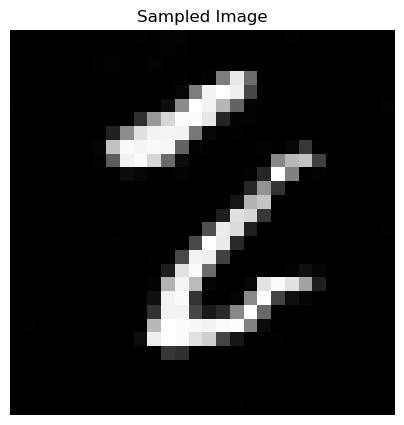

In [19]:
import torch
import matplotlib.pyplot as plt

# Load the saved data
sampled_data = torch.load('sampled_gaussian_ddpm.pt')

# Access a specific entry
index = 66 # Replace with the index you want to check
sampled_image = sampled_data[index]['sampled']


# Convert the tensor to a numpy array
sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)


# Display the sampled image
plt.figure(figsize=(5, 5))
plt.imshow(sampled_image, cmap = 'gray')
plt.title("Sampled Image")
plt.axis('off')
plt.show()
